In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle_dataset'

In [ ]:
%cd /content/kaggle_dataset


/content/kaggle_dataset


In [ ]:
!pwd

/content/kaggle_dataset


In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
100% 563M/565M [00:28<00:00, 19.7MB/s]
100% 565M/565M [00:28<00:00, 20.9MB/s]


In [ ]:
!mkdir fashion_data
!mv fashion-product-images-small.zip fashion_data

mkdir: cannot create directory ‘fashion_data’: File exists


In [ ]:
%cd fashion_data

/content/kaggle_dataset/fashion_data


In [ ]:
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [ ]:
!ls

fashion-product-images-small.zip  images  myntradataset  styles.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine-tuning Clip on Flickr Image Dataset


The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

![image.png](https://miro.medium.com/max/786/1*tg7akErlMSyCLQxrMtQIYw.png)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print('loaded')

loaded


In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g8comabs
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g8comabs
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=242df8eb150d3d23ac9f11a665e41af7ce84199a76a3aa11d00c06707cb0f187
  Stored in directory: /tmp/pip-ephem-wheel-cache-0e9t5y06/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
print("Torch version:", torch.__version__)

Torch version: 2.4.1+cu121


## Load Model & Data

previous translations were generated through a Transformer, see this [link](https://github.com/statscol/clip-fine-tuning)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#preprocess is just a sequential module
model, preprocess = clip.load("RN50x4")

100%|███████████████████████████████████████| 402M/402M [00:37<00:00, 11.3MiB/s]


In [ ]:
!du -h --max-depth=1

832M	./styles
14G	./images
15G	./fashion-dataset
30G	.


In [ ]:
## Get labels

import pandas as pd
labels = pd.read_csv("/content/styles.csv", usecols=range(10))

labels

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44441,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44442,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44443,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44444,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [ ]:
labels = labels.rename(columns={'productDisplayName': 'captions'})

labels.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,captions
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
# Assuming 'id' is the column containing the numbers
labels['filename'] = labels['id'].astype(str) + '.jpg'

# Display the first few rows to verify the changes
labels


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,captions,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44441,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44442,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44443,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44444,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [ ]:
# Assuming 'caption' column exists in merged_df along with 'filename'
new_df = labels[['filename', 'captions']]

# Display the result
new_df


,filename,captions
0,15970.jpg,Turtle Check Men Navy Blue Shirt
1,39386.jpg,Peter England Men Party Blue Jeans
2,59263.jpg,Titan Women Silver Watch
3,21379.jpg,Manchester United Men Solid Black Track Pants
4,53759.jpg,Puma Men Grey T-shirt
...,...,...
44441,17036.jpg,Gas Men Caddy Casual Shoe
44442,6461.jpg,Lotto Men's Soccer Track Flip Flop
44443,18842.jpg,Puma Men Graphic Stellar Blue Tshirt
44444,46694.jpg,Rasasi Women Blue Lady Perfume


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44446 non-null  object
 1   captions  44439 non-null  object
dtypes: object(2)
memory usage: 694.6+ KB


In [ ]:
# 1. Remove rows with missing captions
df_cleaned = new_df.dropna(subset=['captions'])

# 2. Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# 3. Strip leading/trailing whitespace and remove empty strings
df_cleaned['captions'] = df_cleaned['captions'].str.strip()
df_cleaned['filename'] = df_cleaned['filename'].str.strip()
df_cleaned = df_cleaned[df_cleaned['captions'] != ""]
df_cleaned = df_cleaned[df_cleaned['filename'] != ""]

# 4. Ensure correct data types (string)
df_cleaned['captions'] = df_cleaned['captions'].astype(str)
df_cleaned['filename'] = df_cleaned['filename'].astype(str)

# 5. Optionally, remove special characters from captions
df_cleaned['captions'] = df_cleaned['captions'].str.replace(r'[^\w\s]', '', regex=True)

# Check the final cleaned DataFrame
print(df_cleaned.info())
print(df_cleaned.head())


<class 'pandas.core.frame.DataFrame'>
Index: 44439 entries, 0 to 44445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44439 non-null  object
 1   captions  44439 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
None
    filename                                       captions
0  15970.jpg               Turtle Check Men Navy Blue Shirt
1  39386.jpg             Peter England Men Party Blue Jeans
2  59263.jpg                       Titan Women Silver Watch
3  21379.jpg  Manchester United Men Solid Black Track Pants
4  53759.jpg                           Puma Men Grey Tshirt


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44439 entries, 0 to 44445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44439 non-null  object
 1   captions  44439 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [ ]:
train,test=train_test_split(df_cleaned,train_size=0.7)
##make sure when using ImageFolder, idx positions match, ImageFolder will load files in ascending order by filename
train.sort_values(by="filename",ascending=True,inplace=True)
test.sort_values(by="filename",ascending=True,inplace=True)
print(train.shape,test.shape)

(31107, 2) (13332, 2)


In [ ]:
from pathlib import Path

### Copy files to a new directory to load them using torch.datasets api

In [ ]:
!rm -rf /kaggle/working

In [ ]:
import shutil
import os
from tqdm import tqdm
from pathlib import Path

BASE_PATH = "/content/kaggle_dataset/fashion_data/images"

# Ensure directories exist
os.makedirs("/kaggle/working/fashion-dataset/train/images", exist_ok=True)
os.makedirs("/kaggle/working/fashion-dataset/test/images", exist_ok=True)

# Copy train images
for image in tqdm(train.filename, desc="Copying train images"):
    src = Path(BASE_PATH) / image
    dst = Path("/kaggle/working/fashion-dataset/train/images") / image
    try:
        shutil.copyfile(src, dst)
    except FileNotFoundError:
        print(f"File not found: {src}, skipping...")

# Copy test images
for image in tqdm(test.filename, desc="Copying test images"):
    src = Path(BASE_PATH) / image
    dst = Path("/kaggle/working/fashion-dataset/test/images") / image
    try:
        shutil.copyfile(src, dst)
    except FileNotFoundError:
        print(f"File not found: {src}, skipping...")


Copying train images:   8%|▊         | 2535/31107 [00:00<00:04, 6133.51it/s]

File not found: /content/kaggle_dataset/fashion_data/images/12347.jpg, skipping...


Copying train images:  58%|█████▊    | 18086/31107 [00:03<00:02, 6339.24it/s]

File not found: /content/kaggle_dataset/fashion_data/images/39410.jpg, skipping...
File not found: /content/kaggle_dataset/fashion_data/images/39425.jpg, skipping...


Copying test images:  62%|██████▏   | 8234/13332 [00:01<00:00, 6535.47it/s]

File not found: /content/kaggle_dataset/fashion_data/images/39401.jpg, skipping...
File not found: /content/kaggle_dataset/fashion_data/images/39403.jpg, skipping...


Copying test images: 100%|██████████| 13332/13332 [00:01<00:00, 6788.81it/s]


In [ ]:
#using datasets.ImageFolder makes loading images and preprocessing easier
train_images = datasets.ImageFolder("/kaggle/working/fashion-dataset/train/",transform=preprocess)
test_images = datasets.ImageFolder("/kaggle/working/fashion-dataset/test/",transform=preprocess)

In [ ]:
## Create datasets

class FlickerDataset(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.filename=image_tensors

    def __getitem__(self,idx):
        image_idx,_=self.filename[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption':caption_idx}

    def __len__(self):
        return len(self.captions)

train_dataset = FlickerDataset(train.captions.values.tolist(), train_images)
test_dataset = FlickerDataset(test.captions.values.tolist(), test_images)
len(train_dataset), len(test_dataset)


(31107, 13332)

In [ ]:
## create dataloaders
BATCH_SIZE=32
tr_dl=DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
ts_dl=DataLoader(test_dataset,shuffle=True,batch_size=BATCH_SIZE)

In [ ]:
import shutil
import os
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import pandas as pd

BASE_PATH = "/content/kaggle_dataset/fashion_data/images"

# Ensure directories exist
os.makedirs("/kaggle/working/fashion-dataset/train/images", exist_ok=True)
os.makedirs("/kaggle/working/fashion-dataset/test/images", exist_ok=True)

# Function to filter out missing images
def filter_existing_images(df, base_path):
    """
    Filters the DataFrame to only keep rows where the image files exist.
    """
    existing_images = []
    for image in df['filename']:
        if (Path(base_path) / image).exists():
            existing_images.append(True)
        else:
            existing_images.append(False)
    return df[existing_images]

# Filter out missing images from train and test datasets
train_cleaned = filter_existing_images(train, BASE_PATH)
test_cleaned = filter_existing_images(test, BASE_PATH)

# Copy train images
for image in tqdm(train_cleaned.filename, desc="Copying train images"):
    src = Path(BASE_PATH) / image
    dst = Path("/kaggle/working/fashion-dataset/train/images") / image
    try:
        shutil.copyfile(src, dst)
    except FileNotFoundError:
        print(f"File not found: {src}, skipping...")

# Copy test images
for image in tqdm(test_cleaned.filename, desc="Copying test images"):
    src = Path(BASE_PATH) / image
    dst = Path("/kaggle/working/fashion-dataset/test/images") / image
    try:
        shutil.copyfile(src, dst)
    except FileNotFoundError:
        print(f"File not found: {src}, skipping...")

# Using datasets.ImageFolder for easier image loading
train_images = datasets.ImageFolder("/kaggle/working/fashion-dataset/train/", transform=preprocess)
test_images = datasets.ImageFolder("/kaggle/working/fashion-dataset/test/", transform=preprocess)

## Create a custom dataset for captions and images
class FlickerDataset(Dataset):
    def __init__(self, captions, image_tensors):
        self.captions = captions
        self.image_tensors = image_tensors

    def __getitem__(self, idx):
        image_idx, _ = self.image_tensors[idx]  # Get image tensor
        caption_idx = self.captions[idx]  # Get corresponding caption
        return {'image': image_idx, 'caption': caption_idx}

    def __len__(self):
        return len(self.captions)

# Ensure that train and test captions are aligned with the available images
train_dataset = FlickerDataset(train_cleaned.captions.values.tolist(), train_images)
test_dataset = FlickerDataset(test_cleaned.captions.values.tolist(), test_images)

# Check lengths to make sure everything is aligned
print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

# Create DataLoaders
BATCH_SIZE = 32
tr_dl = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
ts_dl = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)


Copying test images: 100%|██████████| 13330/13330 [00:02<00:00, 5861.22it/s]


Train dataset length: 31104
Test dataset length: 13330


In [ ]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS=5
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

## Train Loop and validation

In [ ]:
tr_dl.dataset

In [ ]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

model.to(DEVICE)

DRIVE_CHECKPOINT_PATH = "/content/drive/MyDrive/btp"  # Change this to your desired folder in Drive


## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

def train_model(n_epochs,train_dataloader,test_dataloader,checkpoint_path:str="./checkpoints"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)

    print(f"Using {DEVICE} for training")
    best_score=9999999
    history={'train_loss':[],'val_loss':[]}
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        train_loss=0.0
        model.train()
        for step,data in enumerate(train_dataloader,1):

            optimizer.zero_grad()

            img_batch=data['image'].to(DEVICE)
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            scheduler.step() ##per step scheduler
            if step%100==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                print(f"Lr at step {step}: {optimizer.param_groups[0]['lr']:.5f}")

        history['train_loss'].append(train_loss/len(train_dataloader))
        val_metrics=validate(test_dataloader)
        history['val_loss'].append(val_metrics)
        if val_metrics<best_score:
            print("Better score reached, saving checkpoint...")
            if os.path.exists(Path(checkpoint_path)/"best_model.pt"):
                os.remove(Path(checkpoint_path)/"best_model.pt")
            best_score=val_metrics
            drive_best_model_path = Path(DRIVE_CHECKPOINT_PATH) / "fashion_best_model.pt"
            torch.save(model.state_dict(), Path(checkpoint_path)/"best_model.pt")
            torch.save(model.state_dict(), drive_best_model_path)



    return history


def validate(test_dl):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in validation set"):
        img_batch=data['image'].to(DEVICE)
        captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()

    test_total_loss=test_loss/len(test_dl)
    print(f"Validation Loss {test_total_loss:.3f}")
    return test_total_loss


results=train_model(N_EPOCHS,tr_dl,ts_dl)

Using cuda:0 for training


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-63-81306b674a2f>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 0 step loss:0.404482421875
Lr at step 100: 0.00001
Epoch 0 step loss:0.36463165283203125
Lr at step 200: 0.00001
Epoch 0 step loss:0.34199666341145835
Lr at step 300: 0.00001
Epoch 0 step loss:0.3256137084960937
Lr at step 400: 0.00001
Epoch 0 step loss:0.316774169921875
Lr at step 500: 0.00001
Epoch 0 step loss:0.3089105224609375
Lr at step 600: 0.00001
Epoch 0 step loss:0.30426731654575895
Lr at step 700: 0.00001
Epoch 0 step loss:0.2948556900024414
Lr at step 800: 0.00001
Epoch 0 step loss:0.2900910441080729
Lr at step 900: 0.00001



Evaluating in validation set: 100%|██████████| 417/417 [04:19<00:00,  1.61it/s]


Validation Loss 0.229
Better score reached, saving checkpoint...


 20%|██        | 1/5 [15:55<1:03:40, 955.18s/it]

Epoch 1 step loss:0.1687273406982422
Lr at step 100: 0.00001
Epoch 1 step loss:0.16778438568115234
Lr at step 200: 0.00001
Epoch 1 step loss:0.1722649637858073
Lr at step 300: 0.00001
Epoch 1 step loss:0.17185359954833984
Lr at step 400: 0.00001
Epoch 1 step loss:0.17099087524414064
Lr at step 500: 0.00001
Epoch 1 step loss:0.1713557243347168
Lr at step 600: 0.00001
Epoch 1 step loss:0.16980789729527065
Lr at step 700: 0.00001
Epoch 1 step loss:0.16871857166290283
Lr at step 800: 0.00001
Epoch 1 step loss:0.16896827273898654
Lr at step 900: 0.00001



Evaluating in validation set: 100%|██████████| 417/417 [04:18<00:00,  1.61it/s]


Validation Loss 0.192
Better score reached, saving checkpoint...


 40%|████      | 2/5 [31:48<47:42, 954.18s/it]  

Epoch 2 step loss:0.12395555496215821
Lr at step 100: 0.00001
Epoch 2 step loss:0.11747919082641602
Lr at step 200: 0.00001
Epoch 2 step loss:0.12027823130289714
Lr at step 300: 0.00001
Epoch 2 step loss:0.12108662605285644
Lr at step 400: 0.00001
Epoch 2 step loss:0.1190226058959961
Lr at step 500: 0.00000
Epoch 2 step loss:0.11868556340535481
Lr at step 600: 0.00000
Epoch 2 step loss:0.11670021602085659
Lr at step 700: 0.00000
Epoch 2 step loss:0.11426670789718628
Lr at step 800: 0.00000
Epoch 2 step loss:0.11283677630954318
Lr at step 900: 0.00000



Evaluating in validation set: 100%|██████████| 417/417 [04:18<00:00,  1.62it/s]


Validation Loss 0.156
Better score reached, saving checkpoint...


 60%|██████    | 3/5 [47:38<31:44, 952.28s/it]

Epoch 3 step loss:0.09239617347717285
Lr at step 100: 0.00000
Epoch 3 step loss:0.08366608142852783
Lr at step 200: 0.00000
Epoch 3 step loss:0.08475913683573405
Lr at step 300: 0.00000
Epoch 3 step loss:0.08382636308670044
Lr at step 400: 0.00000
Epoch 3 step loss:0.08274321556091309
Lr at step 500: 0.00000
Epoch 3 step loss:0.08307107130686442
Lr at step 600: 0.00000
Epoch 3 step loss:0.08281890460423061
Lr at step 700: 0.00000
Epoch 3 step loss:0.0813342010974884
Lr at step 800: 0.00000
Epoch 3 step loss:0.08121550771925184
Lr at step 900: 0.00000



Evaluating in validation set: 100%|██████████| 417/417 [04:19<00:00,  1.61it/s]


Validation Loss 0.134
Better score reached, saving checkpoint...


 80%|████████  | 4/5 [1:03:27<15:50, 950.85s/it]

Epoch 4 step loss:0.06904925346374512
Lr at step 100: 0.00000
Epoch 4 step loss:0.06627130031585693
Lr at step 200: 0.00000
Epoch 4 step loss:0.06625917752583822
Lr at step 300: 0.00000
Epoch 4 step loss:0.06602465391159057
Lr at step 400: 0.00000
Epoch 4 step loss:0.06606724452972412
Lr at step 500: 0.00000
Epoch 4 step loss:0.06594385385513306
Lr at step 600: 0.00000
Epoch 4 step loss:0.06646681581224714
Lr at step 700: 0.00000
Epoch 4 step loss:0.06657461941242218
Lr at step 800: 0.00000
Epoch 4 step loss:0.06647896289825439
Lr at step 900: 0.00000



100%|██████████| 5/5 [1:19:12<00:00, 950.41s/it]

Validation Loss 0.135


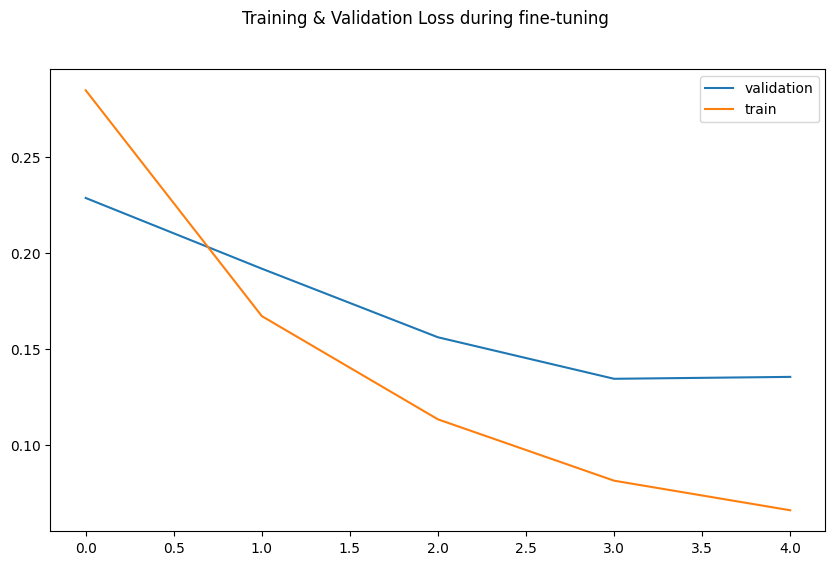

In [ ]:
## lets see loss
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");

In [ ]:
import clip
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load the finetuned model
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50x4", device=DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/btp/fashion_best_model.pt"))
#torch.save(model.state_dict(), '/content/drive/MyDrive/BTP/model/clip_new.pt')

<ipython-input-65-4c9e2bf7a7fc>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/btp/fashion_best_model.pt"))


<All keys matched successfully>

In [ ]:
 # Load your finetuned model
model.eval()

# Preprocess and encode test images
test_images = datasets.ImageFolder("/kaggle/working/fashion-dataset/test/", transform=preprocess)
test_loader = DataLoader(test_images, batch_size=32, shuffle=False)

image_embeddings = []
image_paths = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(DEVICE)
        image_features = model.encode_image(images)
        image_embeddings.append(image_features)
        image_paths.extend([img_path[0] for img_path in test_images.samples])

image_embeddings = torch.cat(image_embeddings).cpu().numpy()


In [ ]:
def calculate_accuracy(logits_image, logits_caption):
    """
    Calculate accuracy by comparing predicted image-caption pairs.
    We can use top-1 accuracy (predicted caption should be the actual one for each image).
    """
    # Get the indices of the highest scoring captions for each image
    preds = torch.argmax(logits_image, dim=1)
    labels = torch.arange(len(logits_image)).to(DEVICE)  # Ground truth: Each image's true caption is in the same position

    # Check how many predictions match the labels
    correct = (preds == labels).sum().item()
    total = labels.size(0)

    return correct / total

def validate_and_get_accuracy(test_dl):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for data in tqdm(test_dl, desc="Evaluating in validation set"):
        img_batch = data['image'].to(DEVICE)
        captions_batch = clip.tokenize(data['caption'], truncate=True).to(DEVICE)

        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)

        labels = torch.arange(len(img_batch)).to(DEVICE)  # True labels for the images
        total_loss = (loss_img(logits_image, labels) + loss_caption(logits_caption, labels)) / 2
        test_loss += total_loss.item()

        # Calculate accuracy
        accuracy = calculate_accuracy(logits_image, logits_caption)
        correct_predictions += accuracy * len(img_batch)
        total_predictions += len(img_batch)

    test_total_loss = test_loss / len(test_dl)
    test_accuracy = correct_predictions / total_predictions

    print(f"Validation Loss: {test_total_loss:.3f}")
    print(f"Test Accuracy: {test_accuracy:.2%}")

    return test_total_loss, test_accuracy

# Call the validate_and_get_accuracy function after training
val_loss, val_accuracy = validate_and_get_accuracy(ts_dl)


Evaluating in validation set: 100%|██████████| 417/417 [02:08<00:00,  3.25it/s]

Validation Loss: 0.141
Test Accuracy: 94.79%


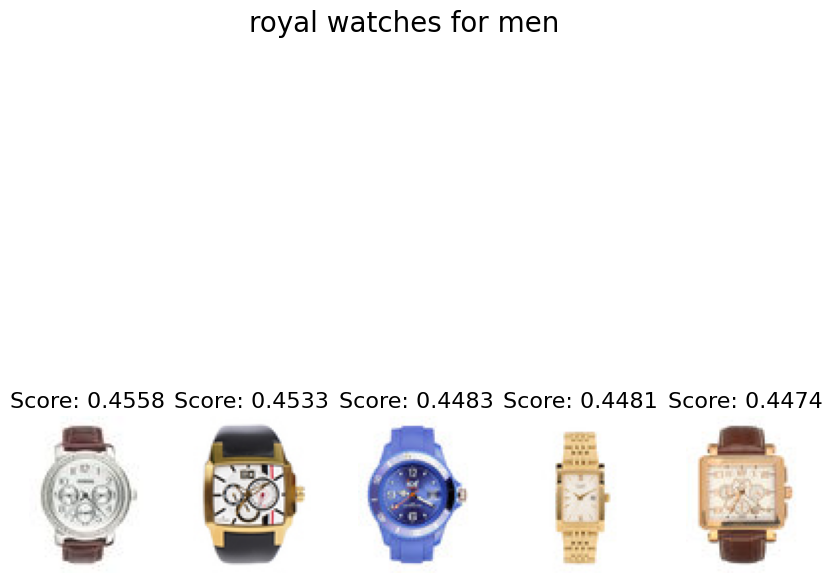

In [ ]:

# Encode the text query
text_query = "royal watches for men"
text_input = clip.tokenize([text_query]).to(DEVICE)

with torch.no_grad():
    text_embedding = model.encode_text(text_input).cpu().numpy()

# Compute similarities
similarities = cosine_similarity(text_embedding, image_embeddings).flatten()

# Retrieve top-k images
top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]
top_images = [image_paths[i] for i in top_indices]
top_scores = [similarities[i] for i in top_indices]

# Display results
plt.figure(figsize=(10, 10))  # Increase the figure size
plt.suptitle(text_query, fontsize=20)  # Add a heading with larger font size

for i, img_path in enumerate(top_images):
    img = Image.open(img_path)
    plt.subplot(1, top_k, i + 1)
    plt.imshow(img)
    plt.title(f"Score: {top_scores[i]:.4f}", fontsize=16)  # Increase the font size of the titles
    plt.axis('off')

plt.subplots_adjust(wspace=0.4)  # Adjust the space between images if needed
plt.show()

